# Prepare radiosondes

This script is for documentation only. Running it requires downloading radiosonde observations (nsainterpolatedsondeC1) from https://wwww.arm.gov/data



In [ ]:
import xarray as xr
import pandas as pn
import numpy as np
import matplotlib.pyplot as plt

import pamtra2
import supporting_routines
%matplotlib inline


## Merge data



In [ ]:
interpolatedsonde = xr.open_mfdataset('/psd3data/oliktok/RawData/ARM/nsa/sonde/nsainterpolatedsondeC1/nsainterpolatedsondeC1.c1.*.nc')



In [ ]:
interpolatedsondeRS = interpolatedsonde.resample(time='6H').nearest(tolerance='1H')

In [ ]:
variables = [
    'temp',
    'rh',
    'bar_pres',
    'dp',
]

for var in variables:
    interpolatedsondeRS[var] = interpolatedsondeRS[var].where(interpolatedsondeRS['qc_%s'%var] == 0)
interpolatedsondeRS = interpolatedsondeRS[variables]

In [ ]:
for k in  list(interpolatedsondeRS.attrs.keys()):
    del interpolatedsondeRS.attrs[k]

In [ ]:
interpolatedsondeRS.to_netcdf('../data/radiosonde_climatology_nsa.nc')

## Estimate prior


In [77]:
# prior = interpolatedsondeRS
prior = xr.open_dataset('../data/radiosonde_climatology_nsa.nc')
prior = prior.dropna('time',how='all')
prior

<xarray.Dataset>
Dimensions:   (height: 332, time: 21174)
Coordinates:
  * time      (time) datetime64[ns] 2002-04-29 ... 2018-01-08T18:00:00
  * height    (height) float32 0.008 0.028 0.048 ... 40.008007 40.508007
Data variables:
    temp      (time, height) float32 -11.4468975 -9.360643 ... nan nan
    rh        (time, height) float32 74.25851 67.062645 72.01327 ... nan nan nan
    bar_pres  (time, height) float32 101.90272 101.88716 101.62322 ... nan nan
    dp        (time, height) float32 -14.990514 -14.00249 -13.726094 ... nan nan

In [78]:
prior['height'] = prior.height*1000
prior['temp'] = prior.temp+273.15
prior['bar_pres'] = prior.bar_pres*1000
prior['rh'] = prior.rh/100
prior['tpot'] = pamtra2.libs.meteo_si.temperature.T_pot(prior['temp'],prior['bar_pres'])


Analyze lower tropospheric stability to identify outliers

/Users/mmaahn/miniconda3/envs/py36/lib/python3.6/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


(array([0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 5.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00, 1.000e+00, 3.000e+00, 4.000e+00, 6.000e+00,
        5.000e+00, 9.000e+00, 1.000e+01, 1.300e+01, 1.700e+01, 2.700e+01,
        1.109e+03, 1.965e+03, 1.907e+03, 2.162e+03, 2.367e+03, 2.437e+03,
        2.377e+03, 1.718e+03, 1.229e+03, 8.760e+02, 4.740e+02, 2.480e+02,
        1.110e+02, 6.800e+01, 3.600e+01, 2.600e+01, 5.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00]),
 array([-50.        , -47.95918367, -45.91836735, -43.87755102,
        -41.83673469, -39.79591837, -37.75510204, -35.71428571,
        -33.67346939, -31.63265306, -29.59183673, -27.55102041,
        -25.51020408, -23.46938776, -21.42857143, -19.3877551 ,
        -17.34693878, -15.30612245, -13.26530612, -11.2244898 ,
         -9.18367347,  -7.14285714,  -5.10204082,  -3.06122449,
   

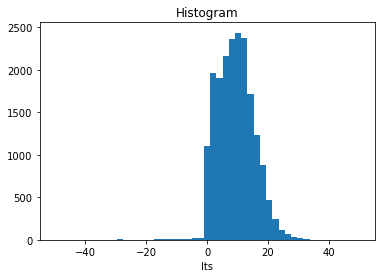

In [79]:
prior['lts'] = prior['tpot'] - prior['tpot'][:,0]
level_925 = np.nanargmin(np.abs(prior.bar_pres.mean('time').values - 92500))
prior['lts'][:,level_925].plot.hist(bins=np.linspace(-50,50).tolist())



(array([0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 3.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 2.000e+00, 4.000e+00, 5.000e+00,
        5.000e+00, 9.000e+00, 9.000e+00, 1.300e+01, 1.500e+01, 2.700e+01,
        1.108e+03, 1.965e+03, 1.905e+03, 2.161e+03, 2.366e+03, 2.436e+03,
        2.377e+03, 1.717e+03, 1.226e+03, 8.730e+02, 4.710e+02, 2.460e+02,
        1.080e+02, 6.700e+01, 3.300e+01, 2.400e+01, 4.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00]),
 array([-50.        , -47.95918367, -45.91836735, -43.87755102,
        -41.83673469, -39.79591837, -37.75510204, -35.71428571,
        -33.67346939, -31.63265306, -29.59183673, -27.55102041,
        -25.51020408, -23.46938776, -21.42857143, -19.3877551 ,
        -17.34693878, -15.30612245, -13.26530612, -11.2244898 ,
         -9.18367347,  -7.14285714,  -5.10204082,  -3.06122449,
   

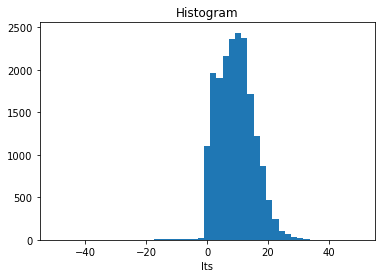

In [80]:
# remove outliers
II = np.where(~((prior['temp'].diff('height') >11).any('height')))[0]

prior = prior.isel(time=II)
prior['lts'][:,level_925].plot.hist(bins=np.linspace(-50,50).tolist())

In [81]:
prior['q'] = pamtra2.libs.meteo_si.humidity.rh2q(prior.rh, prior.temp, prior.bar_pres)*1000

Use only every fifth height

In [82]:
hh = list(range(0,300,5))
prior = prior.isel(height=hh)

As can be seen from the Quantile Quantile plots, q follows a normal distribution better if the log value is taken. 

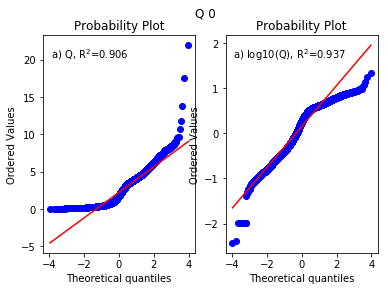

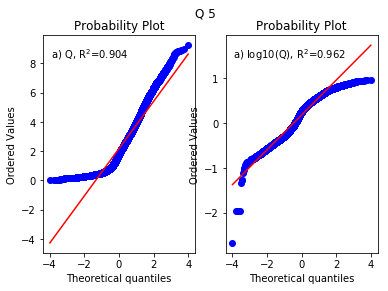

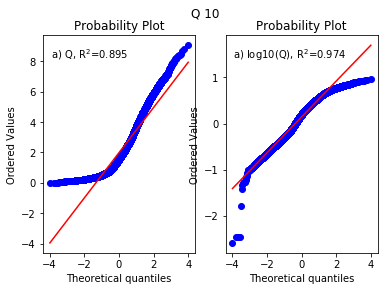

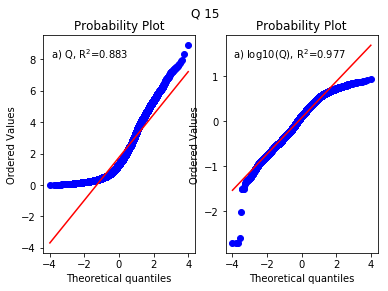

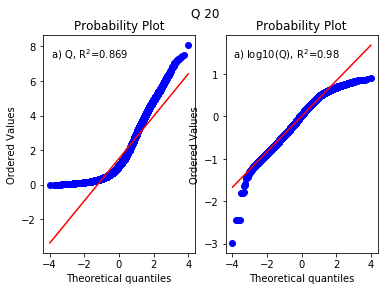

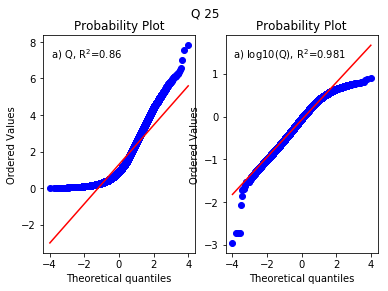

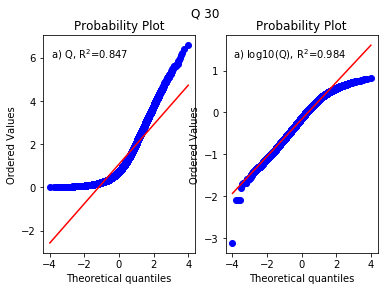

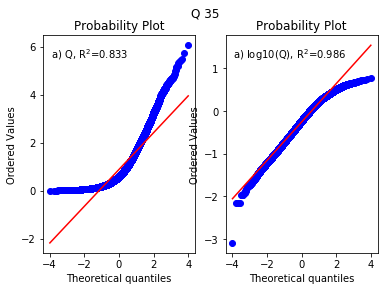

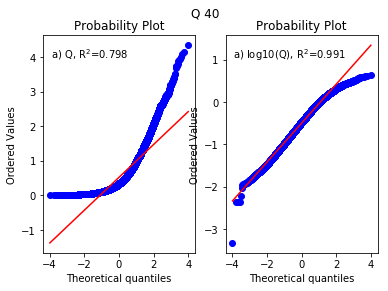

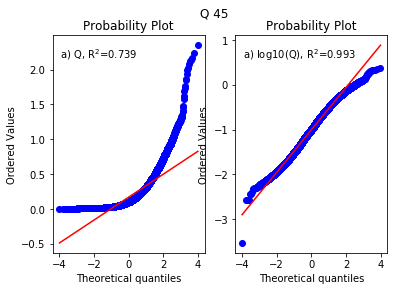

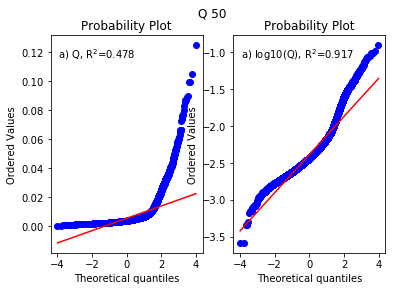

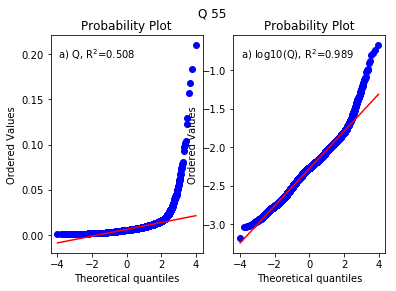

In [86]:
for h in range(0,60,5):
    fig,(ax,ax1) = plt.subplots(ncols=2)
    plt.suptitle('Q %i'%h)
    (osm, osr), (slope, intercept, r) = stats.probplot(
    prior.q.isel(height=h).dropna('time').values,
    dist="norm",
    plot=ax,
    fit=True,
    rvalue=False)
    ax.text(
        0.05,
        0.95,
        '%s) %s, R$^2$=%.3g' % ('a', 'Q', r**2),
        horizontalalignment='left',
        verticalalignment='top',
        transform=ax.transAxes)

    (osm, osr), (slope, intercept, r) = stats.probplot(
    np.log10(prior.q.isel(height=h).dropna('time').values),
    dist="norm",
    plot=ax1,
    fit=True,
    rvalue=False)
    ax1.text(
        0.05,
        0.95,
        '%s) %s, R$^2$=%.3g' % ('a', 'log10(Q)', r**2),
        horizontalalignment='left',
        verticalalignment='top',
        transform=ax1.transAxes)





In [88]:
prior['q'] = np.log10(prior['q'])

Extract profile 

In [90]:
profileII =[2062, 4124, 8248, 16119, 21115]
profile = prior.isel(time=profileII)
prior = prior.drop(labels = profile.time.values, dim='time')
nProf = len(prior.height)


Prepare prior

In [91]:
priors = {
    'all':prior
}

seasons = [
    'DJF',
    'MAM',
    'JJA',
    'SON',
]
months = (
    [12,1,2],
[3,4,5],
[6,7,8],
[9,10,11],
         )
for season, month in zip(seasons, months):
    priors[season] = prior.where(np.in1d(prior['time.month'], month)[:,np.newaxis]).dropna('time',how='all')


    
    

In [92]:
prior_qts = {}
for season in priors.keys():
    prior_q = priors[season]['q'].to_pandas()
    prior_q.columns = ['%05i_q'%(i) for i in  prior_q.columns]
    prior_t = priors[season]['temp'].to_pandas()
    prior_t.columns = ['%05i_t'%(i) for i in  prior_t.columns]
    prior_qts[season] = pn.concat((prior_q,prior_t), axis=1)
    prior_qts[season] = prior_qts[season].reindex(sorted(prior_qts[season].columns), axis=1)
    
prior_qts

{'all':                       00008_q     00008_t   00107_q     00107_t   00207_q  \
 time                                                                        
 2002-04-29 00:00:00  0.064744  261.703094  0.120490  262.642944  0.121120   
 2002-04-29 06:00:00  0.026484  260.471436  0.111891  261.733887  0.115678   
 2002-04-29 12:00:00 -0.012288  259.239807  0.032706  259.375885  0.046552   
 2002-04-29 18:00:00 -0.051580  258.008148 -0.048208  257.017883 -0.023759   
 2002-04-30 00:00:00  0.058703  261.549988 -0.023267  260.049225 -0.026649   
 2002-04-30 06:00:00  0.058703  261.549988 -0.130510  256.795776 -0.154667   
 2002-04-30 12:00:00  0.058703  261.549988 -0.241314  253.542343 -0.286981   
 2002-04-30 18:00:00  0.058703  261.549988 -0.355826  250.288895 -0.423945   
 2002-05-01 00:00:00  0.058703  261.549988 -0.433016  248.122696 -0.517152   
 2002-05-01 06:00:00  0.058703  261.549988 -0.311570  251.274063 -0.376730   
 2002-05-01 12:00:00  0.058703  261.549988 -0.193527  254

In [93]:
x_cov = []
x_mean = []

for season in ['all'] + seasons:

    x_cov1 = prior_qts[season].cov()
    x_mean1 = prior_qts[season].mean()
    
    x_cov1 = x_cov1.rename_axis('state', axis=0).rename_axis('state_T',axis=1)
    x_mean1 = x_mean1.rename_axis('state', axis=0)

    x_cov.append(xr.DataArray(x_cov1))
    x_mean.append(xr.DataArray(x_mean1))


x_cov = xr.concat(x_cov, dim='season')
x_mean = xr.concat(x_mean, dim='season')


x_cov['season'] = ['all'] + seasons
x_mean['season'] = ['all'] + seasons



In [94]:
pressure = []
for k in ['all'] + seasons:
    pressure.append(priors[k].bar_pres.mean('time'))
pressure = xr.concat(pressure, dim='season')
pressure['season'] = ['all'] + seasons


In [95]:
for season in x_cov.season:
    print(np.linalg.matrix_rank(x_cov.sel(season=season).to_pandas()),  x_cov.shape[-1])
    assert np.linalg.matrix_rank(x_cov.sel(season=season).to_pandas()) ==  x_cov.shape[-1]
    
    
    

120 120
120 120
120 120
120 120
120 120


Text(0, 0.5, 'Height [m]')

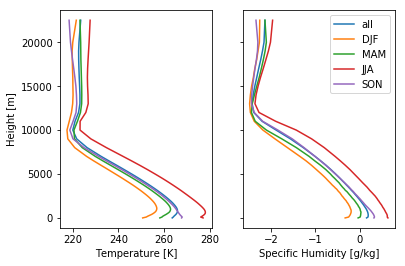

In [96]:
fig, (ax1,ax2) = plt.subplots(ncols=2, sharey=True)
for season in ['all'] +seasons:
    t,q = supporting_routines.splitTQ(x_mean.sel(season=season).to_pandas())
    ax1.plot( t, t.index,label=season)
    ax2.plot( q, q.index,label=season)

ax2.legend()
ax1.set_xlabel('Temperature [K]')
ax2.set_xlabel('Specific Humidity [g/kg]')
ax1.set_ylabel('Height [m]')

In [97]:
profile_t = profile['temp'].to_pandas()
profile_t.columns = ['%05i_t'%(i) for i in  profile_t.columns]
profile_q = profile['q'].to_pandas()
profile_q.columns = ['%05i_q'%(i) for i in  profile_q.columns]

x_truth = pn.concat((profile_t,profile_q), 1)
x_truth = x_truth.reindex(sorted(x_truth.index), axis=0)
x_truth.columns.name = 'state'
x_truth.index.name = 'time'
x_truth = xr.DataArray(x_truth)

assert np.all(np.isfinite(x_truth))

In [99]:
mergedData = xr.Dataset({
    'x_truth': x_truth,
    'x_mean': x_mean,
    'x_cov': x_cov,
    'pressure': pressure,
})

mergedData.to_netcdf('../data/radiosonde_prior.nc')
mergedData

<xarray.Dataset>
Dimensions:   (height: 60, season: 5, state: 120, state_T: 120, time: 5)
Coordinates:
  * state     (state) object '00008_q' '00008_t' ... '22508_q' '22508_t'
  * time      (time) datetime64[ns] 2004-03-16T12:00:00 ... 2018-01-08T12:00:00
  * season    (season) <U3 'all' 'DJF' 'MAM' 'JJA' 'SON'
  * state_T   (state_T) object '00008_q' '00008_t' ... '22508_q' '22508_t'
  * height    (height) float32 8.0 107.99999 207.99997 ... 20008.008 22508.008
Data variables:
    x_truth   (time, state) float32 -0.4302439 248.2671 ... -2.6492734 211.00235
    x_mean    (season, state) float32 0.15051249 263.561 ... 218.33395
    x_cov     (season, state, state_T) float64 0.2196 5.755 ... 1.075 27.61
    pressure  (season, height) float32 101407.44 100186.98 ... 3597.4702